In [1]:
%matplotlib inline
import pickle
import csv
import os

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.preprocessing import normalize
from sklearn.model_selection import GridSearchCV, GroupKFold, cross_val_score, KFold
import shap

from model_util import *

In [2]:
predict_targets = [
    'contact_type',
    'q1_want',
    'q2_talk',
    'q3_loan',
    'q4_closeness'
]

replace_dict = {
    'contact_type': {
        "work": 0,
        "friend": 1,
        "task": 2,
        "family_live_separate": 1,
        "family_live_together": 3,
        "sig_other": 3
    }
}

# replace_dict = {
#     'contact_type': {
#         "work": 0,
#         "friend": 1,
#         "task": 2,
#         "family_live_separate": 3,
#         "family_live_together": 4,
#         "sig_other": 5
#     }
# }


#contact_types = list(replace_dict['contact_type'].keys())
contact_types = ["work", "social", "task", "family_together"]

## Build top 5 final features

In [12]:
# with open("../data/all_contacts_no_other.df", "rb") as f:
#     all_contacts_raw = pickle.load(f)
    
# with open("../data/old_raw/top_5_contacts_loc_final.df", "rb") as f:
#     old_top5_raw = pickle.load(f)
    
# print(old_top5_raw.shape)
# print(all_contacts_raw.shape)

# top5_combined_hashes = old_top5_raw['combined_hash'].unique()

# top5_raw = all_contacts_raw.loc[all_contacts_raw['combined_hash'].isin(top5_combined_hashes)]

# with open("../data/top5_final.df", "wb") as f:
#     pickle.dump(top5_raw, f, -1)

## Build top 10 final features

In [13]:
# with open("../data/all_contacts_no_other.df", "rb") as f:
#     all_contacts_raw = pickle.load(f)
    
# with open("../data/old_raw/top_10_contacts_loc_final.df", "rb") as f:
#     old_top10_raw = pickle.load(f)
    
# print(old_top10_raw.shape)
# print(all_contacts_raw.shape)

# top10_combined_hashes = old_top10_raw['combined_hash'].unique()

# top10_raw = all_contacts_raw.loc[all_contacts_raw['combined_hash'].isin(top10_combined_hashes)]

# with open("../data/top10_final.df", "wb") as f:
#     pickle.dump(top10_raw, f, -1)

## Random Forest: age/gender features only

In [22]:
ag_baseline_train_data = pickle.load(open('../data/final_features_jan28/top_5_age_gender_train_features.df', 'rb'))
ag_baseline_test_data = pickle.load(open('../data/final_features_jan28/top_5_age_gender_test_features.df', 'rb'))

ag_baseline_train_data = ag_baseline_train_data.replace(replace_dict)
ag_baseline_test_data = ag_baseline_test_data.replace(replace_dict)

ag_baseline_train_y = ag_baseline_train_data['contact_type']
ag_baseline_train_X = ag_baseline_train_data[ag_baseline_train_data.columns[ag_baseline_train_data.columns.str.startswith("ego")]]
ag_baseline_train_X = normalize(ag_baseline_train_X)
ag_baseline_test_y = ag_baseline_test_data['contact_type']
ag_baseline_test_X = ag_baseline_test_data[ag_baseline_train_data.columns[ag_baseline_train_data.columns.str.startswith("ego")]]
ag_baseline_test_X = normalize(ag_baseline_test_X)

ag_baseline_clf = RandomForestClassifier(random_state=2, n_jobs=4, n_estimators=100, warm_start=False)

groups = build_cv_groups(ag_baseline_train_data['pid'])
group_kfold = GroupKFold(n_splits=10)


# param_grid = {
#     #'n_estimators': [50, 100, 200, 300, 500, 1000]
#     'n_estimators': [500]
# }

# ag_baseline_grid_clf = GridSearchCV(clf, param_grid, n_jobs=4, cv=group_kfold.split(ag_baseline_train_X, 
#                                                               ag_baseline_train_y, 
#                                                               groups),
#                                 scoring='f1_weighted')
                              
# ag_baseline_grid_clf.fit(ag_baseline_train_X, ag_baseline_train_y)

# cv_scores = cross_val_score(ag_baseline_clf, ag_baseline_train_X, ag_baseline_train_y, cv=group_kfold.split(ag_baseline_train_X, ag_baseline_train_y, groups))
# print(cv_scores)    
# print(np.mean(cv_scores))


# ag_baseline_X = ag_baseline_train_X.append(ag_baseline_test_X)
# ag_baseline_y = ag_baseline_train_y.append(ag_baseline_test_y)

# groups = build_cv_groups(ag_baseline_train_data['pid'].append(ag_baseline_test_data['pid']))
# group_kfold = GroupKFold(n_splits=10)

# cv_scores = cross_val_score(clf, ag_baseline_X, ag_baseline_y, cv=group_kfold.split(ag_baseline_X, ag_baseline_y, groups), scoring='f1_weighted')

cv_scores = cross_val_score(ag_baseline_clf, ag_baseline_train_X, ag_baseline_train_y, cv=group_kfold.split(ag_baseline_train_X, ag_baseline_train_y, groups))

print(cv_scores)    
print(np.mean(cv_scores))

[0.52       0.41333333 0.48       0.6        0.41333333 0.57333333
 0.65333333 0.51428571 0.52857143 0.62857143]
0.5324761904761905


In [42]:
ag_baseline_clf.fit(ag_baseline_train_X, ag_baseline_train_y)
pred = ag_baseline_clf.predict(ag_baseline_test_X)
stats_df = print_clf_metrics(ag_baseline_test_y, pred, contact_types)

Accuracy: 0.5428571428571428


/home/tliu526/miniconda3/envs/shap/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/tliu526/miniconda3/envs/shap/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


precision    recall        F1
macro      0.226754  0.249811  0.211521
weighted   0.415121  0.542857  0.439258

p_work  p_social  p_task  p_family_together
work                  0        14       0                  2
social                4       109       0                  7
task                  0        18       0                  1
family_together       1        49       0                  5

In [46]:
from collections import Counter

Counter(ag_baseline_test_X.values)

AttributeError: 'numpy.ndarray' object has no attribute 'values'

## Random Forest: communication features only

In [38]:
# baseline_train_data = pickle.load(open('../data/final_features/all_contacts_baseline_dedup_nan_train_features.df', 'rb'))
# baseline_test_data = pickle.load(open('../data/final_features/all_contacts_baseline_dedup_nan_test_features.df', 'rb'))

baseline_train_data = pickle.load(open('../data/final_features_jan28/top_5_baseline_train_features.df', 'rb'))
baseline_test_data = pickle.load(open('../data/final_features_jan28/top_5_baseline_test_features.df', 'rb'))

# baseline_train_data = pickle.load(open('../data/final_features/top10_baseline_dedup_nan_train_features.df', 'rb'))
# baseline_test_data = pickle.load(open('../data/final_features/top10_baseline_dedup_nan_test_features.df', 'rb'))

baseline_train_data = baseline_train_data.replace(replace_dict)
baseline_test_data = baseline_test_data.replace(replace_dict)

baseline_train_y = baseline_train_data['contact_type']
baseline_train_X = baseline_train_data.drop(['pid', 'combined_hash'] + predict_targets, axis=1, errors='ignore')
baseline_train_X = normalize(baseline_train_X)
baseline_test_y = baseline_test_data['contact_type']
baseline_test_X = baseline_test_data.drop(['pid', 'combined_hash'] + predict_targets, axis=1, errors='ignore')
baseline_test_X = normalize(baseline_test_X)

baseline_clf = RandomForestClassifier(random_state=2, n_jobs=4, n_estimators=100, warm_start=False)

groups = build_cv_groups(baseline_train_data['pid'])
group_kfold = GroupKFold(n_splits=10)


# param_grid = {
#     #'n_estimators': [50, 100, 200, 300, 500, 1000]
#     'n_estimators': [500]
# }

# baseline_grid_clf = GridSearchCV(clf, param_grid, n_jobs=4, cv=group_kfold.split(baseline_train_X, 
#                                                               baseline_train_y, 
#                                                               groups),
#                                 scoring='f1_weighted')
                              
# baseline_grid_clf.fit(baseline_train_X, baseline_train_y)

# cv_scores = cross_val_score(baseline_clf, baseline_train_X, baseline_train_y, cv=group_kfold.split(baseline_train_X, baseline_train_y, groups))
# print(cv_scores)    
# print(np.mean(cv_scores))


# baseline_X = baseline_train_X.append(baseline_test_X)
# baseline_y = baseline_train_y.append(baseline_test_y)

# groups = build_cv_groups(baseline_train_data['pid'].append(baseline_test_data['pid']))
# group_kfold = GroupKFold(n_splits=10)

# cv_scores = cross_val_score(clf, baseline_X, baseline_y, cv=group_kfold.split(baseline_X, baseline_y, groups), scoring='f1_weighted')

cv_scores = cross_val_score(baseline_clf, baseline_train_X, baseline_train_y, cv=group_kfold.split(baseline_train_X, baseline_train_y, groups))

print(cv_scores)    
print(np.mean(cv_scores))

[0.76       0.65333333 0.66666667 0.58666667 0.61333333 0.64
 0.77333333 0.55714286 0.71428571 0.67142857]
0.6636190476190477


In [39]:
baseline_clf.fit(baseline_train_X, baseline_train_y)
pred = baseline_clf.predict(baseline_test_X)
print_clf_metrics(baseline_test_y, pred, contact_types)

Accuracy: 0.6714285714285714


/home/tliu526/miniconda3/envs/shap/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/tliu526/miniconda3/envs/shap/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


precision    recall        F1
macro      0.510031  0.447588  0.461076
weighted   0.615917  0.671429  0.624965

p_work  p_social  p_task  p_family_together
work                  0        13       1                  2
social                0       110       0                 10
task                  0         8       9                  2
family_together       0        31       2                 22

precision    recall        F1
macro      0.510031  0.447588  0.461076
weighted   0.615917  0.671429  0.624965

In [34]:
importances = baseline_clf.feature_importances_
feature_labels = baseline_train_X.columns.values
imp_df = pd.DataFrame(importances, index=feature_labels, columns=['imp'])
display(imp_df.sort_values('imp', ascending=False).head())

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

## RF: comm + age/sex

In [40]:
age_gender_train_data = pickle.load(open('../data/final_features/all_contacts_age_gender_dedup_nan_train_features.df', 'rb'))
age_gender_test_data = pickle.load(open('../data/final_features/all_contacts_age_gender_dedup_nan_test_features.df', 'rb'))

age_gender_train_data = pickle.load(open('../data/final_features_jan28/top_5_age_gender_train_features.df', 'rb'))
age_gender_test_data = pickle.load(open('../data/final_features_jan28/top_5_age_gender_test_features.df', 'rb'))

#age_gender_train_data = pickle.load(open('../data/final_features/top10_age_gender_train_features.df', 'rb'))
#age_gender_test_data = pickle.load(open('../data/final_features/top10_age_gender_test_features.df', 'rb'))

age_gender_train_data = age_gender_train_data.replace(replace_dict)
age_gender_test_data = age_gender_test_data.replace(replace_dict)

age_gender_train_y = age_gender_train_data['contact_type']
age_gender_train_X = age_gender_train_data.drop(['pid', 'combined_hash'] + predict_targets, axis=1, errors='ignore')
age_gender_train_X = normalize(age_gender_train_X)
age_gender_test_y = age_gender_test_data['contact_type']
age_gender_test_X = age_gender_test_data.drop(['pid', 'combined_hash'] + predict_targets, axis=1, errors='ignore')
age_gender_test_X = normalize(age_gender_test_X)


groups = build_cv_groups(age_gender_train_data['pid'])
group_kfold = GroupKFold(n_splits=10)


age_gender_clf = RandomForestClassifier(random_state=2, n_jobs=4, n_estimators=100, warm_start=False)


# param_grid = {
#     #'n_estimators': [50, 100, 200, 300, 500,1000]
#     'n_estimators': [500]
# }

# age_gender_grid_clf = GridSearchCV(clf,  param_grid, n_jobs=4, cv=group_kfold.split(age_gender_train_X, 
#                                                               age_gender_train_y, 
#                                                               groups),
#                                   scoring='f1_macro')
                              
# age_gender_grid_clf.fit(age_gender_train_X, age_gender_train_y)

# age_gender_X = age_gender_train_X.append(age_gender_test_X)
# age_gender_y = age_gender_train_y.append(age_gender_test_y)

# groups = build_cv_groups(age_gender_train_data['pid'].append(age_gender_test_data['pid']))
# group_kfold = GroupKFold(n_splits=10)

# cv_scores = cross_val_score(clf, age_gender_X, age_gender_y, cv=group_kfold.split(age_gender_X, age_gender_y, groups), scoring='f1_weighted')

cv_scores = cross_val_score(age_gender_clf, age_gender_train_X, age_gender_train_y, cv=group_kfold.split(age_gender_train_X, age_gender_train_y, groups))

print(cv_scores)    
print(np.mean(cv_scores))

[0.72       0.65333333 0.69333333 0.61333333 0.6        0.65333333
 0.77333333 0.57142857 0.74285714 0.64285714]
0.6663809523809524


In [41]:
age_gender_clf.fit(age_gender_train_X, age_gender_train_y)
pred = age_gender_clf.predict(age_gender_test_X)
stats_df = print_clf_metrics(age_gender_test_y, pred, contact_types)

Accuracy: 0.680952380952381


/home/tliu526/miniconda3/envs/shap/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/tliu526/miniconda3/envs/shap/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


precision    recall        F1
macro      0.521586  0.467753  0.480623
weighted   0.626745  0.680952  0.638217

p_work  p_social  p_task  p_family_together
work                  0        14       1                  1
social                0       109       0                 11
task                  0         7      10                  2
family_together       0        29       2                 24

In [37]:
importances = age_gender_clf.feature_importances_
feature_labels = age_gender_train_X.columns.values
imp_df = pd.DataFrame(importances, index=feature_labels, columns=['imp'])
display(imp_df.sort_values('imp', ascending=False))

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

## RF: demographics

In [32]:
demo_train_data = pickle.load(open('../data/final_features/all_contacts_demo_dedup_nan_train_features.df', 'rb'))
demo_test_data = pickle.load(open('../data/final_features/all_contacts_demo_dedup_nan_test_features.df', 'rb'))

demo_train_data = pickle.load(open('../data/final_features_jan28/top_5_demo_train_features.df', 'rb'))
demo_test_data = pickle.load(open('../data/final_features_jan28/top_5_demo_test_features.df', 'rb'))

#demo_train_data = pickle.load(open('../data/final_features/top10_demo_dedup_nan_train_features.df', 'rb'))
#demo_test_data = pickle.load(open('../data/final_features/top10_demo_dedup_nan_test_features.df', 'rb'))

demo_train_data = demo_train_data.replace(replace_dict)
demo_test_data = demo_test_data.replace(replace_dict)

demo_train_y = demo_train_data['contact_type']
demo_train_X = demo_train_data.drop(['pid', 'combined_hash'] + predict_targets, axis=1, errors='ignore')
demo_test_y = demo_test_data['contact_type']
demo_test_X = demo_test_data.drop(['pid', 'combined_hash'] + predict_targets, axis=1, errors='ignore')

groups = build_cv_groups(demo_train_data['pid'])
group_kfold = GroupKFold(n_splits=10)

demo_clf = RandomForestClassifier(random_state=2, n_jobs=4, n_estimators=500, warm_start=False)


# param_grid = {
#     #'n_estimators': [50, 100, 200, 300, 500,1000]
#     'n_estimators': [500]
# }

# demo_grid_clf = GridSearchCV(clf,  param_grid, n_jobs=4, cv=group_kfold.split(demo_train_X, 
#                                                               demo_train_y, 
#                                                               groups),
#                                   scoring='f1_weighted')
                              
# demo_grid_clf.fit(demo_train_X, demo_train_y)

# demo_X = demo_train_X.append(demo_test_X)
# demo_y = demo_train_y.append(demo_test_y)

# groups = build_cv_groups(demo_train_data['pid'].append(demo_test_data['pid']))
# group_kfold = GroupKFold(n_splits=10)

# cv_scores = cross_val_score(clf, demo_X, demo_y, cv=group_kfold.split(demo_X, demo_y, groups), scoring='f1_weighted')

cv_scores = cross_val_score(demo_clf, demo_train_X, demo_train_y, cv=group_kfold.split(demo_train_X, demo_train_y, groups))
print(cv_scores)    
print(np.mean(cv_scores))

[0.70666667 0.64       0.68       0.58666667 0.57333333 0.68
 0.76       0.5        0.7        0.68571429]
0.6512380952380953


In [33]:
demo_clf.fit(demo_train_X, demo_train_y)
pred = demo_clf.predict(demo_test_X)
stats_df = print_clf_metrics(demo_test_y, pred, contact_types)

Accuracy: 0.6714285714285714


/home/tliu526/miniconda3/envs/shap/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/tliu526/miniconda3/envs/shap/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


precision    recall        F1
macro      0.526650  0.467275  0.479258
weighted   0.622754  0.671429  0.625386

p_work  p_social  p_task  p_family_together
work                  0        16       0                  0
social                0       109       1                 10
task                  0         7      11                  1
family_together       0        32       2                 21

In [35]:
importances = demo_clf.feature_importances_
feature_labels = demo_train_X.columns.values
imp_df = pd.DataFrame(importances, index=feature_labels, columns=['imp'])
display(imp_df.sort_values('imp', ascending=False))

imp
reg_comm                           0.027665
total_comm_days                    0.025445
total_comms                        0.021876
reg_sms                            0.020409
time_of_day_5_sms                  0.020110
day_0_sms                          0.019832
total_sms_days                     0.018448
time_of_day_4_sms                  0.018357
out_comm                           0.017822
avg_in_duration                    0.017771
total_sms                          0.017464
total_calls                        0.017295
avg_out_duration                   0.017275
reg_call                           0.016694
total_days                         0.016582
time_of_day_3_sms                  0.016456
mean_out_call                      0.016326
day_5_sms                          0.016048
time_of_day_2_sms                  0.016022
day_6_sms                          0.016010
std_out_sms                        0.015721
mean_out_sms                       0.015553
ego_age                            0.015372
mean_in_call                       0.014988
med_out_sms                        0.014786
day_2_sms                          0.014751
time_of_day_2_calls                0.014701
day_4_sms                          0.014669
max_out_duration                   0.014615
std_out_call                       0.014333
...                                     ...
day_5_sms_nan_indicator            0.000626
day_6_calls_nan_indicator          0.000626
max_out_sms_nan_indicator          0.000621
std_out_call_nan_indicator         0.000618
mean_out_sms_nan_indicator         0.000614
day_4_calls_nan_indicator          0.000600
time_of_day_5_sms_nan_indicator    0.000579
mean_out_call_nan_indicator        0.000566
day_5_calls_nan_indicator          0.000557
min_out_call_nan_indicator         0.000551
min_in_call_nan_indicator          0.000541
max_in_call_nan_indicator          0.000530
day_1_calls_nan_indicator          0.000518
time_of_day_5_calls_nan_indicator  0.000516
day_2_sms_nan_indicator            0.000512
max_out_call_nan_indicator         0.000500
time_of_day_3_calls_nan_indicator  0.000497
time_of_day_4_calls_nan_indicator  0.000485
day_2_calls_nan_indicator          0.000485
time_of_day_2_calls_nan_indicator  0.000473
day_3_calls_nan_indicator          0.000458
med_out_call_nan_indicator         0.000450
day_0_calls_nan_indicator          0.000427
time_of_day_0_calls_nan_indicator  0.000411
ego_education_pro_doctoral         0.000409
mean_in_call_nan_indicator         0.000401
std_in_call_nan_indicator          0.000369
ego_race_prefer_no_answer          0.000318
ego_marital_status_widowed         0.000285
ego_employment_retired             0.000135

[151 rows x 1 columns]

In [37]:
import lime

explainer = lime.lime_tabular.LimeTabularExplainer(demo_train_X.values, feature_names=demo_train_X.columns.values,
                                                   class_names=contact_types, discretize_continuous=True)

In [38]:
demo_clf.predict_proba

<bound method ForestClassifier.predict_proba of RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=4,
            oob_score=False, random_state=2, verbose=0, warm_start=False)>

In [45]:
i = np.random.randint(0, demo_test_X.shape[0])
exp = explainer.explain_instance(demo_test_X.values[i], demo_clf.predict_proba, num_features=4, top_labels=1)
exp.show_in_notebook(show_table=True, show_all=True)

## RF all features

In [131]:
all_train_data = pickle.load(open('../data/final_features/all_contacts_all_dedup_nan_train_features.df', 'rb'))
all_test_data = pickle.load(open('../data/final_features/all_contacts_all_dedup_nan_test_features.df', 'rb'))

#all_train_data = pickle.load(open('../data/final_features/top5_all_train_features.df', 'rb'))
#all_test_data = pickle.load(open('../data/final_features/top5_all_test_features.df', 'rb'))

#all_train_data = pickle.load(open('../data/final_features/top10_all_dedup_nan_train_features.df', 'rb'))
#all_test_data = pickle.load(open('../data/final_features/top10_all_dedup_nan_test_features.df', 'rb'))

all_train_data = all_train_data.replace(replace_dict)
all_test_data = all_test_data.replace(replace_dict)

all_train_y = all_train_data['contact_type']
all_train_X = all_train_data.drop(['pid', 'combined_hash'] + predict_targets, axis=1, errors='ignore')
all_test_y = all_test_data['contact_type']
all_test_X = all_test_data.drop(['pid', 'combined_hash'] + predict_targets, axis=1, errors='ignore')

groups = build_cv_groups(all_train_data['pid'])
group_kfold = GroupKFold(n_splits=10)


all_clf = RandomForestClassifier(random_state=2, n_jobs=4, n_estimators=1000, warm_start=False)


# param_grid = {
#     #'n_estimators': [50, 100, 200, 300, 500,1000]
#     'n_estimators': [500]
# }

# all_grid_clf = GridSearchCV(clf,  param_grid, n_jobs=4, cv=group_kfold.split(all_train_X, 
#                                                               all_train_y, 
#                                                               groups),
#                                   scoring='f1_weighted')
                              
# all_grid_clf.fit(all_train_X, all_train_y)

all_X = all_train_X.append(all_test_X)
all_y = all_train_y.append(all_test_y)

groups = build_cv_groups(all_train_data['pid'].append(all_test_data['pid']))
group_kfold = GroupKFold(n_splits=10)

cv_scores = cross_val_score(clf, all_X, all_y, cv=group_kfold.split(all_X, all_y, groups), scoring='f1_weighted')

#cv_scores = cross_val_score(clf, all_train_X, all_train_y, cv=group_kfold.split(all_train_X, all_train_y, groups))
print(cv_scores)    
print(np.mean(cv_scores))

[0.58495348 0.53600244 0.51606851 0.55024776 0.58658227 0.55774554
 0.48914596 0.54693685 0.52053288 0.55865314]
0.5446868846028018


In [132]:
all_clf.fit(all_train_X, all_train_y)
pred = all_clf.predict(all_test_X)
stats_df = print_clf_metrics(all_test_y, pred, contact_types)

Accuracy: 0.6361339229311433


precision    recall        F1
macro      0.522459  0.451098  0.437235
weighted   0.579632  0.636134  0.581628

p_work  p_social  p_task  p_family_together
work                  8       124      99                  1
social               11       491      98                 16
task                 16        99     486                  0
family_together       0        74      38                 22

In [133]:
importances = all_clf.feature_importances_
feature_labels = all_train_X.columns.values
imp_df = pd.DataFrame(importances, index=feature_labels, columns=['imp'])
display(imp_df.sort_values('imp', ascending=False))

imp
ego_age                               0.022571
reg_comm                              0.022438
reg_call                              0.016270
mean_out_sms                          0.015750
reg_sms                               0.014459
std_out_sms                           0.013894
med_out_sms                           0.013593
time_of_day_3_comm                    0.013092
total_comms                           0.012959
tot_call_duration                     0.012519
max_out_sms                           0.012405
call_dur_last_6_wks                   0.011618
call_dur_last_2_wks                   0.011000
time_of_day_2_comm_out                0.010725
total_sms                             0.010411
out_comm                              0.010222
time_of_day_2_comm                    0.009503
time_of_day_3_comm_out                0.009285
total_comm_days                       0.009187
total_sms_days                        0.009023
time_of_day_1_comm                    0.008917
avg_out_duration                      0.008349
max_out_duration                      0.008179
med_out_duration                      0.008098
time_of_day_2_call_dur                0.008074
day_6_comm                            0.008061
mean_out_call                         0.007878
day_0_comm                            0.007870
std_out_call                          0.007728
day_2_comm                            0.007621
...                                        ...
all_call_visit_reason:entertainment   0.000651
ego_marital_status_widowed            0.000628
all_sms_loc:outdoors/recreation       0.000625
all_sms_visit_reason:entertainment    0.000533
ego_education_pro_doctoral            0.000516
time_of_day_0_long_call_out           0.000487
all_sms_visit_reason:travel/traffic   0.000483
time_of_day_0_miss_call_out           0.000372
all_call_visit_reason:travel/traffic  0.000367
time_of_day_0_long_call_in            0.000355
time_of_day_0_miss_call_in            0.000348
all_sms_loc:spiritual                 0.000321
all_sms_loc:nightlife                 0.000317
ego_gender_other                      0.000316
all_call_loc:outdoors/recreation      0.000302
all_sms_loc:arts/entertainment        0.000269
all_sms_loc:vehicle                   0.000256
all_call_loc:spiritual                0.000248
ego_employment_retired                0.000246
all_sms_loc:travel/transport          0.000235
all_call_loc:nightlife                0.000221
all_call_loc:travel/transport         0.000185
all_call_loc:arts/entertainment       0.000169
all_sms_loc:gym/exercise              0.000151
all_sms_visit_reason:exercise         0.000151
all_call_loc:gym/exercise             0.000149
all_call_visit_reason:exercise        0.000112
all_call_loc:vehicle                  0.000093
all_sms_loc:other                     0.000000
all_call_loc:other                    0.000000

[249 rows x 1 columns]

## Zimmerman RF baseline

In [12]:
mapping_dict = {
    'contact_type': {
        "work": 0,
        "social": 1,
        "family": 2
    }
    #{v:idx for idx, v in enumerate(zimmerman_contact_types)}
}
z_contact_types = ['work', 'social', 'family']

baseline_train_data = pickle.load(open('../data/zimmerman_features/zimmerman_contact_type_baseline_train_features.df', 'rb'))
baseline_test_data = pickle.load(open('../data/zimmerman_features/zimmerman_contact_type_baseline_test_features.df', 'rb'))

baseline_train_data = baseline_train_data.replace(mapping_dict)
baseline_test_data = baseline_test_data.replace(mapping_dict)

baseline_train_y = baseline_train_data['contact_type']
baseline_train_X = baseline_train_data.drop(['pid', 'combined_hash'] + predict_targets, axis=1, errors='ignore')
baseline_test_y = baseline_test_data['contact_type']
baseline_test_X = baseline_test_data.drop(['pid', 'combined_hash'] + predict_targets, axis=1, errors='ignore')

clf = RandomForestClassifier(random_state=2, n_jobs=4, n_estimators=100, warm_start=False)

groups = build_cv_groups(baseline_train_data['pid'])
group_kfold = GroupKFold(n_splits=10)


param_grid = {
    #'n_estimators': [50, 100, 200, 300, 500, 1000]
    'n_estimators': [100]
}

baseline_grid_clf = GridSearchCV(clf, param_grid, n_jobs=4, cv=group_kfold.split(baseline_train_X, 
                                                              baseline_train_y, 
                                                              groups),
                                scoring='f1_macro')
                              
baseline_grid_clf.fit(baseline_train_X, baseline_train_y)



GridSearchCV(cv=<generator object _BaseKFold.split at 0x7f52152f0750>,
       error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=4,
            oob_score=False, random_state=2, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid={'n_estimators': [100]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='f1_macro',
       verbose=0)

In [13]:
print(baseline_grid_clf.best_score_)
print(baseline_grid_clf.best_params_)
pred = baseline_grid_clf.predict(baseline_test_X)
print_clf_metrics(baseline_test_y, pred, z_contact_types)

0.47637600519497914
{'n_estimators': 100}
Accuracy: 0.5151821862348178


precision    recall        F1
macro      0.513595  0.495093  0.499095
weighted   0.515035  0.515182  0.511021

p_work  p_social  p_family
work        83        81        69
social      37       211       119
family      44       129       215

precision    recall        F1
macro      0.513595  0.495093  0.499095
weighted   0.515035  0.515182  0.511021

In [14]:
mapping_dict = {
    'contact_type': {
        "work": 0,
        "social": 1,
        "family": 2
    }
    #{v:idx for idx, v in enumerate(zimmerman_contact_types)}
}
z_contact_types = ['work', 'social', 'family']

age_gender_train_data = pickle.load(open('../data/zimmerman_features/zimmerman_contact_type_age_gender_train_features.df', 'rb'))
age_gender_test_data = pickle.load(open('../data/zimmerman_features/zimmerman_contact_type_age_gender_test_features.df', 'rb'))

age_gender_train_data = age_gender_train_data.replace(mapping_dict)
age_gender_test_data = age_gender_test_data.replace(mapping_dict)

age_gender_train_y = age_gender_train_data['contact_type']
age_gender_train_X = age_gender_train_data.drop(['pid', 'combined_hash'] + predict_targets, axis=1, errors='ignore')
age_gender_test_y = age_gender_test_data['contact_type']
age_gender_test_X = age_gender_test_data.drop(['pid', 'combined_hash'] + predict_targets, axis=1, errors='ignore')

clf = RandomForestClassifier(random_state=2, n_jobs=4, n_estimators=100, warm_start=False)

groups = build_cv_groups(age_gender_train_data['pid'])
group_kfold = GroupKFold(n_splits=10)


param_grid = {
    #'n_estimators': [50, 100, 200, 300, 500, 1000]
    'n_estimators': [100]
}

age_gender_grid_clf = GridSearchCV(clf, param_grid, n_jobs=4, cv=group_kfold.split(age_gender_train_X, 
                                                              age_gender_train_y, 
                                                              groups),
                                scoring='f1_macro')
                              
age_gender_grid_clf.fit(age_gender_train_X, age_gender_train_y)



GridSearchCV(cv=<generator object _BaseKFold.split at 0x7f52152f0b88>,
       error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=4,
            oob_score=False, random_state=2, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid={'n_estimators': [100]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='f1_macro',
       verbose=0)

In [15]:
print(age_gender_grid_clf.best_score_)
print(age_gender_grid_clf.best_params_)
pred = age_gender_grid_clf.predict(age_gender_test_X)
print_clf_metrics(age_gender_test_y, pred, z_contact_types)

0.471526397711288
{'n_estimators': 100}
Accuracy: 0.5121457489878543


precision    recall        F1
macro      0.506711  0.490506  0.493839
weighted   0.510336  0.512146  0.507555

p_work  p_social  p_family
work        80        84        69
social      41       205       121
family      44       123       221

precision    recall        F1
macro      0.506711  0.490506  0.493839
weighted   0.510336  0.512146  0.507555

In [16]:
importances = age_gender_grid_clf.best_estimator_.feature_importances_
feature_labels = age_gender_train_X.columns.values
imp_df = pd.DataFrame(importances, index=feature_labels, columns=['imp'])
display(imp_df.sort_values('imp', ascending=False))

imp
ego_age                            0.029357
reg_comm                           0.026273
reg_call                           0.017600
time_of_day_3_comm                 0.016807
time_of_day_2_comm_out             0.015000
reg_sms                            0.014907
total_comms                        0.014682
day_5_comm                         0.013842
time_of_day_2_comm                 0.013583
std_out_sms                        0.013466
tot_call_duration                  0.012714
mean_out_sms                       0.012290
time_of_day_1_comm                 0.012252
time_of_day_3_comm_out             0.012148
day_3_comm                         0.010869
total_sms                          0.010709
day_1_comm                         0.010638
day_4_comm                         0.010605
out_comm                           0.010551
time_of_day_1_comm_out             0.010514
call_dur_last_2_wks                0.010190
day_6_comm                         0.010068
day_4_comm_out                     0.009952
day_0_comm                         0.009758
std_in_sms                         0.009738
comm_last_2_wks                    0.009529
call_dur_last_6_wks                0.009518
max_out_sms                        0.009505
day_2_comm                         0.009491
total_comm_days                    0.009477
...                                     ...
time_of_day_0_sms_nan_indicator    0.000428
time_of_day_0_long_call_out        0.000423
day_2_sms_nan_indicator            0.000420
time_of_day_0_call_nan_indicator   0.000419
min_in_call_nan_indicator          0.000401
mean_in_call_nan_indicator         0.000398
day_0_call_nan_indicator           0.000391
call_dur_last_6_wks_nan_indicator  0.000365
day_1_call_nan_indicator           0.000355
day_6_call_nan_indicator           0.000344
tot_call_duration_nan_indicator    0.000324
mean_in_sms_nan_indicator          0.000323
std_in_call_nan_indicator          0.000322
call_last_2_wks_nan_indicator      0.000318
min_out_call_nan_indicator         0.000304
time_of_day_0_long_call_in         0.000300
med_in_call_nan_indicator          0.000291
call_dur_last_2_wks_nan_indicator  0.000289
std_out_call_nan_indicator         0.000289
time_of_day_3_call_nan_indicator   0.000284
day_2_call_nan_indicator           0.000280
day_3_call_nan_indicator           0.000277
med_out_call_nan_indicator         0.000273
time_of_day_0_miss_call_out        0.000267
time_of_day_1_call_nan_indicator   0.000256
mean_out_call_nan_indicator        0.000236
day_4_call_nan_indicator           0.000230
time_of_day_2_call_nan_indicator   0.000199
max_out_call_nan_indicator         0.000190
max_in_call_nan_indicator          0.000188

[279 rows x 1 columns]

## Feature analysis

- Cohen's d
- Spearman correlation for age
- t-test for significance
- violin plot (group box plot):
    - gender split
- scatter plot per contact type (loess plot):
    - y is contact frequency, x is age
- try 10-fold CV

## Shap analysis

In [4]:
import shap
import autosklearn.metrics
import pickle

In [5]:
shap.initjs()

In [6]:
# original autosklearn models
# auto-sklearn models


automl_models_4clf = []
automl_preds_4clf = []
features = ['baseline', 'age_gender', 'demo', 'loc', 'all']

for feat in features[:-1]:
    with open("../model/rd3_results/top_5_contact_type_{}.automl".format(feat), 'rb') as model_file:
            automl_models_4clf.append(pickle.load(model_file))
    with open("../model/rd3_results/top_5_contact_type_{}.predict".format(feat), 'rb') as pred_file:
        automl_preds_4clf.append(pickle.load(pred_file))
        

with open("../model/rd3_results/top_5_contact_type_all_long.automl", 'rb') as model_file:
    automl_models_4clf.append(pickle.load(model_file))
with open("../model/rd3_results/top_5_contact_type_all_long.predict", 'rb') as pred_file:
    automl_preds_4clf.append(pickle.load(pred_file))

/home/tliu526/miniconda3/envs/shap/lib/python3.7/site-packages/pyparsing.py:2910: FutureWarning: Possible set intersection at position 3
  self.re = re.compile( self.reString )


## Baseline AutoML

In [20]:
base_automl = automl_models_4clf[0]
baseline_train_data = pickle.load(open('../data/final_features_jan28/top_5_baseline_train_features.df', 'rb'))
baseline_test_data = pickle.load(open('../data/final_features_jan28/top_5_baseline_test_features.df', 'rb'))

baseline_train_data = baseline_train_data.replace(replace_dict)
baseline_test_data = baseline_test_data.replace(replace_dict)

baseline_train_y = baseline_train_data['contact_type']
baseline_train_X = baseline_train_data.drop(['pid', 'combined_hash'] + predict_targets, axis=1, errors='ignore')
baseline_test_y = baseline_test_data['contact_type']
baseline_test_X = baseline_test_data.drop(['pid', 'combined_hash'] + predict_targets, axis=1, errors='ignore')


In [21]:
base_automl.refit(baseline_train_X, baseline_train_y)

AutoSklearnClassifier(delete_output_folder_after_terminate=True,
           delete_tmp_folder_after_terminate=True,
           disable_evaluator_output=False, ensemble_nbest=50,
           ensemble_size=50, exclude_estimators=None,
           exclude_preprocessors=None, get_smac_object_callback=None,
           include_estimators=None, include_preprocessors=None,
           initial_configurations_via_metalearning=25,
           ml_memory_limit=3072, output_folder=None,
           per_run_time_limit=1440,
           resampling_strategy=<class 'sklearn.model_selection._split.GroupKFold'>,
           resampling_strategy_arguments={'folds': 5, 'groups': array([  0,   0, ..., 146, 146])},
           seed=2, shared_mode=False, smac_scenario_args=None,
           time_left_for_this_task=14400, tmp_folder=None)

In [27]:
explainer = shap.KernelExplainer(base_automl.predict_proba, shap.kmeans(baseline_train_X, 10), link="logit")

In [ ]:
shap_values = explainer.shap_values(baseline_test_X, nsamples=100)
shap.force_plot(explainer.expected_value[0], shap_values[0][0,:], baseline_test_X.iloc[0,:], link="logit")


In [29]:
shap.force_plot(explainer.expected_value[0], shap_values[0], baseline_test_X, link="logit")


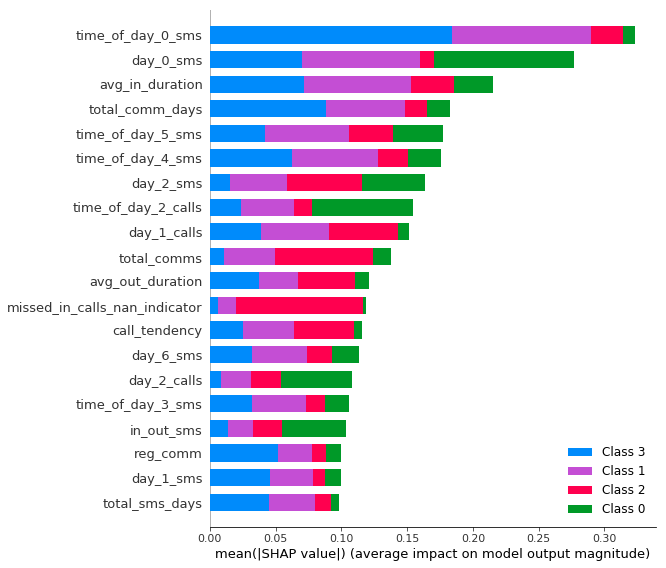

In [30]:
shap.summary_plot(shap_values, baseline_test_X)

## AutoML with age and gender

In [9]:
age_gender_automl = automl_models_4clf[1]
age_gender_train_data = pickle.load(open('../data/final_features_jan28/top_5_age_gender_train_features.df', 'rb'))
age_gender_test_data = pickle.load(open('../data/final_features_jan28/top_5_age_gender_test_features.df', 'rb'))

age_gender_train_data = age_gender_train_data.replace(replace_dict)
age_gender_test_data = age_gender_test_data.replace(replace_dict)

age_gender_train_y = age_gender_train_data['contact_type']
age_gender_train_X = age_gender_train_data.drop(['pid', 'combined_hash'] + predict_targets, axis=1, errors='ignore')
age_gender_test_y = age_gender_test_data['contact_type']
age_gender_test_X = age_gender_test_data.drop(['pid', 'combined_hash'] + predict_targets, axis=1, errors='ignore')


In [10]:
age_gender_automl.refit(age_gender_train_X, age_gender_train_y)

AutoSklearnClassifier(delete_output_folder_after_terminate=True,
           delete_tmp_folder_after_terminate=True,
           disable_evaluator_output=False, ensemble_nbest=50,
           ensemble_size=50, exclude_estimators=None,
           exclude_preprocessors=None, get_smac_object_callback=None,
           include_estimators=None, include_preprocessors=None,
           initial_configurations_via_metalearning=25,
           ml_memory_limit=3072, output_folder=None,
           per_run_time_limit=1440,
           resampling_strategy=<class 'sklearn.model_selection._split.GroupKFold'>,
           resampling_strategy_arguments={'folds': 5, 'groups': array([  0,   0, ..., 146, 146])},
           seed=2, shared_mode=False, smac_scenario_args=None,
           time_left_for_this_task=14400, tmp_folder=None)

In [14]:
pickle.dump(age_gender_automl.predict_proba, open("feature_importance/age_gender.predict_proba", "wb"), -1)
pickle.dump(age_gender_shap_values, open("feature_importance/age_gender.shap_values", "wb"), -1)

In [11]:
age_gender_explainer = shap.KernelExplainer(age_gender_automl.predict_proba, shap.kmeans(age_gender_train_X, 10), link="logit")

In [ ]:
age_gender_shap_values = age_gender_explainer.shap_values(age_gender_test_X, nsamples=50)


In [38]:
shap.force_plot(age_gender_explainer.expected_value[0], age_gender_shap_values[0], age_gender_test_X, link="logit")

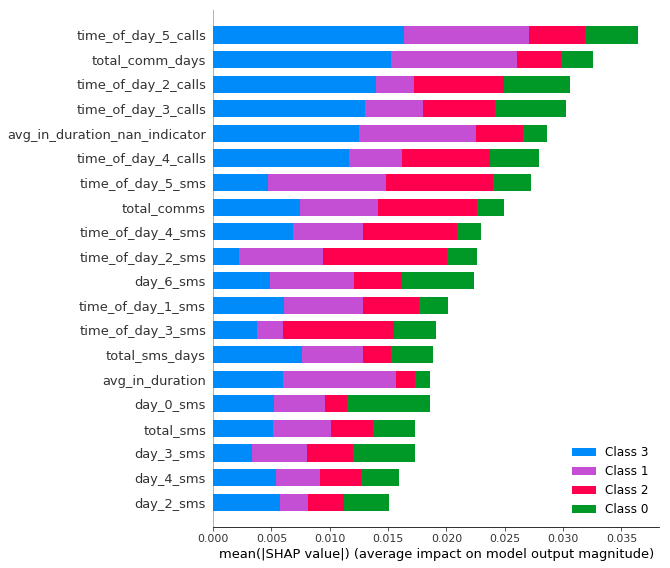

In [36]:
shap.summary_plot(age_gender_shap_values, age_gender_test_X)

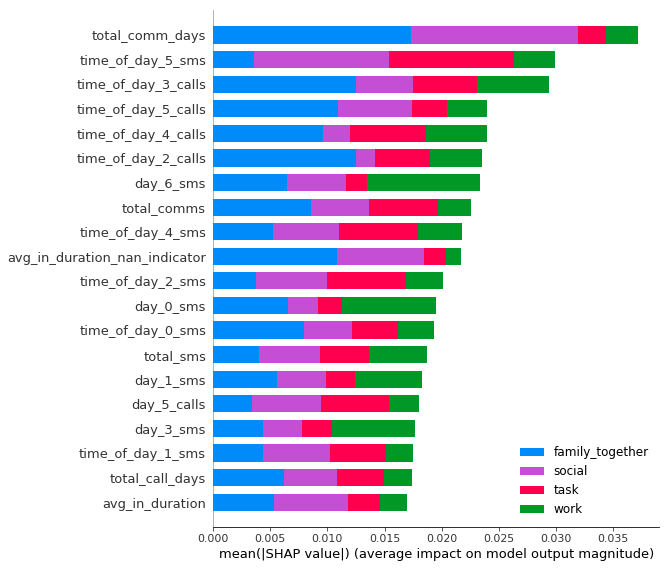

In [19]:
contact_types = ["work", "social", "task", "family_together"]
shap.summary_plot(age_gender_shap_values, age_gender_test_X, plot_type='violin', class_names=contact_types)

In [50]:
np.where(age_gender_test_X.columns.values=='ego_age')

(array([118]),)

## AutoML SHAP with all features

In [7]:
all_automl = automl_models_4clf[-1]
all_train_data = pickle.load(open('../data/final_features_jan28/top_5_all_train_features.df', 'rb'))
all_test_data = pickle.load(open('../data/final_features_jan28/top_5_all_test_features.df', 'rb'))

all_train_data = all_train_data.replace(replace_dict)
all_test_data = all_test_data.replace(replace_dict)

all_train_y = all_train_data['contact_type']
all_train_X = all_train_data.drop(['pid', 'combined_hash'] + predict_targets, axis=1, errors='ignore')
all_test_y = all_test_data['contact_type']
all_test_X = all_test_data.drop(['pid', 'combined_hash'] + predict_targets, axis=1, errors='ignore')


In [8]:
all_automl.refit(all_train_X, all_train_y)

AutoSklearnClassifier(delete_output_folder_after_terminate=True,
           delete_tmp_folder_after_terminate=True,
           disable_evaluator_output=False, ensemble_nbest=50,
           ensemble_size=50, exclude_estimators=None,
           exclude_preprocessors=None, get_smac_object_callback=None,
           include_estimators=None, include_preprocessors=None,
           initial_configurations_via_metalearning=25,
           ml_memory_limit=3072, output_folder=None,
           per_run_time_limit=2160,
           resampling_strategy=<class 'sklearn.model_selection._split.GroupKFold'>,
           resampling_strategy_arguments={'folds': 5, 'groups': array([  0,   0, ..., 146, 146])},
           seed=2, shared_mode=False, smac_scenario_args=None,
           time_left_for_this_task=21600, tmp_folder=None)

In [16]:
all_explainer = shap.KernelExplainer(all_automl.predict_proba, shap.kmeans(all_train_X, 5), link="logit")

In [19]:
all_shap_values = all_explainer.shap_values(all_test_X, nsamples=100, l1_reg='bic')




  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 1/210 [00:02<07:31,  2.16s/it]/home/tliu526/miniconda3/envs/shap/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 55 iterations, i.e. alpha=2.665e-05, with an active set of 35 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/tliu526/miniconda3/envs/shap/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 78 iterations, i.e. alpha=1.333e-05, with an active set of 42 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/tliu526/miniconda3/envs/shap/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in 

  2%|▏         | 4/210 [00:07<06:50,  1.99s/it]

  2%|▏         | 5/210 [00:09<06:41,  1.96s/it]

  3%|▎         | 6/210 [00:11<06:47,  2.00s/it]

  3%|▎         | 7/210 [00:14<07:08,  2.11s/it]

  4%|▍         | 8/210 [00:16<07:04,  2.10s/it]

  4%|▍         | 9/210 [00:18<06:42,  2.00s/it]

  5%|▍         | 10/210 [00:21<07:37,  2.29s/it]

  5%|▌         | 11/210 [00:23<07:34,  2.28s/it]

  6%|▌         | 12/210 [00:25<07:34,  2.30s/it]

  6%|▌         | 13/210 [00:27<07:13,  2.20s/it]

  7%|▋         | 14/210 [00:29<06:47,  2.08s/it]

  7%|▋         | 15/210 [00:31<06:26,  1.98s/it]/home/tliu526/miniconda3/envs/shap/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 73 iterations, i.e. alpha=2.026e-06, with an active set of 43 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/tliu526/minicond

/home/tliu526/miniconda3/envs/shap/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 97 iterations, i.e. alpha=5.675e-07, with an active set of 51 regressors, and the smallest cholesky pivot element being 7.451e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/tliu526/miniconda3/envs/shap/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 97 iterations, i.e. alpha=5.621e-07, with an active set of 51 regressors, and the smallest cholesky pivot element being 3.942e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/tliu526/miniconda3/envs/shap/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 97 iterations, i.e. alpha=5.613e-07, wi

 13%|█▎        | 28/210 [00:55<05:44,  1.89s/it]

 14%|█▍        | 29/210 [00:58<06:09,  2.04s/it]

 14%|█▍        | 30/210 [01:00<06:52,  2.29s/it]/home/tliu526/miniconda3/envs/shap/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 77 iterations, i.e. alpha=3.745e-07, with an active set of 47 regressors, and the smallest cholesky pivot element being 3.332e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/tliu526/miniconda3/envs/shap/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 81 iterations, i.e. alpha=3.389e-07, with an active set of 49 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/tliu526/miniconda3/envs/shap/lib/python3.7/site-packages/sklearn/linear_mo

/home/tliu526/miniconda3/envs/shap/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 81 iterations, i.e. alpha=1.072e-06, with an active set of 49 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/tliu526/miniconda3/envs/shap/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 83 iterations, i.e. alpha=7.036e-07, with an active set of 49 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/tliu526/miniconda3/envs/shap/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 83 iterations, i.e. alpha=6.961e-07, wi



 30%|██▉       | 62/210 [02:08<04:35,  1.86s/it]

 30%|███       | 63/210 [02:10<04:35,  1.88s/it]

 30%|███       | 64/210 [02:12<04:30,  1.85s/it]

 31%|███       | 65/210 [02:14<04:27,  1.84s/it]

 31%|███▏      | 66/210 [02:16<04:25,  1.85s/it]

 32%|███▏      | 67/210 [02:17<04:25,  1.86s/it]

 32%|███▏      | 68/210 [02:19<04:21,  1.84s/it]

 33%|███▎      | 69/210 [02:21<04:15,  1.81s/it]

 33%|███▎      | 70/210 [02:23<04:07,  1.76s/it]

 34%|███▍      | 71/210 [02:24<04:02,  1.74s/it]

 34%|███▍      | 72/210 [02:26<04:00,  1.74s/it]

 35%|███▍      | 73/210 [02:28<03:55,  1.72s/it]

 35%|███▌      | 74/210 [02:29<03:52,  1.71s/it]

 36%|███▌      | 75/210 [02:31<03:52,  1.72s/it]

 36%|███▌      | 76/210 [02:33<03:50,  1.72s/it]

 37%|███▋      | 77/210 [02:35<03:58,  1.79s/it]

 37%|███▋      | 78/210 [02:37<04:07,  1.87s/it]

 38%|███▊      | 79/210 [02:39<04:01,  1.84s/it]/home/tliu526/miniconda3/envs/shap/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:3

 41%|████▏     | 87/210 [02:53<03:41,  1.80s/it]

 42%|████▏     | 88/210 [02:55<03:48,  1.87s/it]

 42%|████▏     | 89/210 [02:57<03:47,  1.88s/it]

 43%|████▎     | 90/210 [02:59<03:43,  1.87s/it]

 43%|████▎     | 91/210 [03:01<03:41,  1.86s/it]/home/tliu526/miniconda3/envs/shap/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=1.613e-03, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/tliu526/miniconda3/envs/shap/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 73 iterations, i.e. alpha=2.970e-04, with an active set of 21 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  Co



 54%|█████▍    | 113/210 [03:41<03:04,  1.90s/it]

 54%|█████▍    | 114/210 [03:43<03:02,  1.91s/it]

 55%|█████▍    | 115/210 [03:45<03:02,  1.92s/it]

 55%|█████▌    | 116/210 [03:47<03:00,  1.92s/it]/home/tliu526/miniconda3/envs/shap/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 71 iterations, i.e. alpha=7.083e-06, with an active set of 43 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/tliu526/miniconda3/envs/shap/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 92 iterations, i.e. alpha=2.129e-06, with an active set of 46 regressors, and the smallest cholesky pivot element being 4.470e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/tliu526/miniconda3

 56%|█████▌    | 117/210 [03:49<02:59,  1.93s/it]/home/tliu526/miniconda3/envs/shap/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 79 iterations, i.e. alpha=1.072e-06, with an active set of 47 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/tliu526/miniconda3/envs/shap/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:337: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 80 iterations, alpha=1.067e-06, previous alpha=1.056e-06, with an active set of 47 regressors.
  ConvergenceWarning)
/home/tliu526/miniconda3/envs/shap/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e

 59%|█████▊    | 123/210 [03:59<02:34,  1.77s/it]

 59%|█████▉    | 124/210 [04:01<02:32,  1.77s/it]/home/tliu526/miniconda3/envs/shap/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 14 iterations, i.e. alpha=5.631e-03, with an active set of 14 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/tliu526/miniconda3/envs/shap/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:337: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 143 iterations, alpha=1.390e-03, previous alpha=1.390e-03, with an active set of 38 regressors.
  ConvergenceWarning)
/home/tliu526/miniconda3/envs/shap/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degene

/home/tliu526/miniconda3/envs/shap/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=2.921e-03, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/tliu526/miniconda3/envs/shap/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 55 iterations, i.e. alpha=7.667e-04, with an active set of 29 regressors, and the smallest cholesky pivot element being 8.162e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/tliu526/miniconda3/envs/shap/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 57 iterations, i.e. alpha=7.430e-04, with



 68%|██████▊   | 143/210 [04:36<02:01,  1.81s/it]

 69%|██████▊   | 144/210 [04:37<01:58,  1.79s/it]

 69%|██████▉   | 145/210 [04:39<01:56,  1.80s/it]

 70%|██████▉   | 146/210 [04:41<01:52,  1.75s/it]/home/tliu526/miniconda3/envs/shap/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=1.102e-03, with an active set of 8 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/tliu526/miniconda3/envs/shap/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 27 iterations, i.e. alpha=3.101e-04, with an active set of 21 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/tliu526/miniconda3/e



 72%|███████▏  | 151/210 [04:50<01:49,  1.86s/it]

 72%|███████▏  | 152/210 [04:52<01:45,  1.82s/it]/home/tliu526/miniconda3/envs/shap/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=3.032e-03, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/tliu526/miniconda3/envs/shap/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 97 iterations, i.e. alpha=4.123e-04, with an active set of 23 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/tliu526/miniconda3/envs/shap/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regr

 73%|███████▎  | 153/210 [04:54<01:43,  1.81s/it]/home/tliu526/miniconda3/envs/shap/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.482e-03, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/tliu526/miniconda3/envs/shap/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 19 iterations, i.e. alpha=4.672e-04, with an active set of 15 regressors, and the smallest cholesky pivot element being 1.825e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/tliu526/miniconda3/envs/shap/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:337: ConvergenceWarning: Early stopping the lars path, as the residues are small a

 86%|████████▌ | 180/210 [05:44<00:58,  1.94s/it]

 86%|████████▌ | 181/210 [05:47<01:01,  2.12s/it]

 87%|████████▋ | 182/210 [05:49<00:58,  2.10s/it]/home/tliu526/miniconda3/envs/shap/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 43 iterations, i.e. alpha=2.379e-05, with an active set of 31 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/tliu526/miniconda3/envs/shap/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 67 iterations, i.e. alpha=7.902e-06, with an active set of 39 regressors, and the smallest cholesky pivot element being 2.356e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/tliu526/miniconda3/envs/shap/lib/python3.7/site-packages/sklearn/linear



 92%|█████████▏| 193/210 [06:09<00:31,  1.86s/it]

 92%|█████████▏| 194/210 [06:11<00:29,  1.83s/it]

 93%|█████████▎| 195/210 [06:12<00:27,  1.81s/it]

 93%|█████████▎| 196/210 [06:14<00:25,  1.79s/it]

 94%|█████████▍| 197/210 [06:16<00:23,  1.79s/it]

 94%|█████████▍| 198/210 [06:18<00:21,  1.82s/it]

 95%|█████████▍| 199/210 [06:20<00:20,  1.84s/it]

 95%|█████████▌| 200/210 [06:22<00:18,  1.86s/it]

 96%|█████████▌| 201/210 [06:24<00:17,  1.93s/it]

 96%|█████████▌| 202/210 [06:26<00:15,  1.95s/it]

 97%|█████████▋| 203/210 [06:27<00:13,  1.90s/it]

 97%|█████████▋| 204/210 [06:29<00:11,  1.86s/it]

 98%|█████████▊| 205/210 [06:31<00:09,  1.81s/it]

 98%|█████████▊| 206/210 [06:33<00:07,  1.84s/it]

 99%|█████████▊| 207/210 [06:35<00:05,  1.88s/it]

 99%|█████████▉| 208/210 [06:37<00:03,  1.90s/it]/home/tliu526/miniconda3/envs/shap/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, a

In [21]:
pickle.dump(all_automl.predict_proba, open("feature_importance/all.predict_proba", "wb"), -1)
pickle.dump(all_shap_values, open("feature_importance/all.shap_values", "wb"), -1)

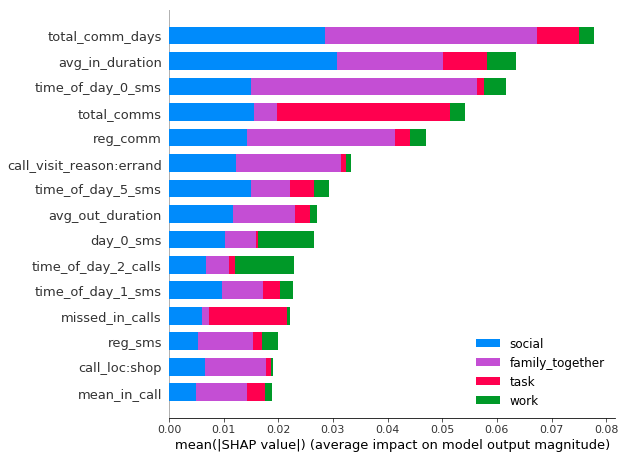

In [35]:
contact_types = ["work", "social", "task", "family_together"]
shap.summary_plot(all_shap_values, all_test_X, plot_type='violin', class_names=contact_types, max_display=15)

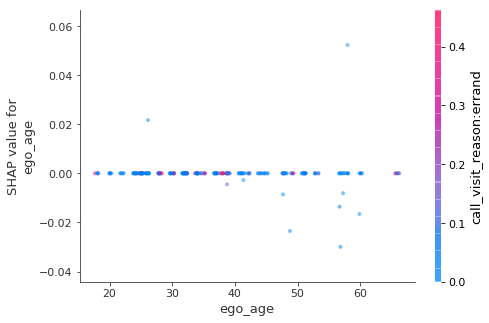

In [31]:
shap.dependence_plot('ego_age', all_shap_values[2], all_test_X, interaction_index='call_visit_reason:errand', alpha=0.5, x_jitter=0.8)

In [22]:
pred = all_automl.predict(all_test_X)
print_clf_metrics(all_test_y, pred, contact_types)

Accuracy: 0.7095238095238096


precision    recall        F1
macro      0.809257  0.522104  0.551859
weighted   0.734306  0.709524  0.680569

p_work  p_social  p_task  p_family_together
work                  1        15       0                  0
social                0       106       1                 13
task                  0         7      11                  1
family_together       0        23       1                 31

precision    recall        F1
macro      0.809257  0.522104  0.551859
weighted   0.734306  0.709524  0.680569